In [1]:
import os

import matplotlib

import numpy as np
import pandas as pd

from scipy import stats

from matplotlib import pyplot as plt

In [29]:
# Rutas de archivos.
path_i = "../data/Indices/"
path_d = "../results/onset/"
path_r = "../results/onset/graficas/"

# Si no existe la carpeta, la crea.
if not os.path.exists(path_r):
    os.mkdir(path_r)

dates = pd.read_csv(path_d + "onset_CHIRPS.csv", index_col = "Año")
# Se convierten las fechas a días julianos.
for i in [0, 1]:
    dates.iloc[:, i] = dates.iloc[:, i].apply(
        lambda x: pd.to_datetime(x) ).apply(lambda x: x.dayofyear)
dates.iloc[:, 2] = dates.iloc[:, 2].apply(lambda x: x[:-5]).astype(int)

# Periodo de media móvil a usar.
m = 0
# Mes final de promedio anual.
M = 12
# Eliminar el primer año
if M < 12: N = 1
else:      N = 0

dates_Y = dates[N:]

cols = ["Año"] + [i for i in range(1, 13)]

BEST_1 = pd.read_table( path_i + "BEST_1M", sep = "\s+",
    names = cols, index_col = 0 ).loc[1981:2020]
BEST_3 = pd.read_table( path_i + "BEST_3M", sep = "\s+",
    names = cols, index_col = 0 ).loc[1981:2020]
BEST_5 = pd.read_table( path_i + "BEST_5M", sep = "\s+",
    names = cols, index_col = 0 ).loc[1981:2020]

BEST = [BEST_1, BEST_3, BEST_5]

# Correlation boostrapping.

def pcorr(x, y, axis):
    if x.ndim == 1: 
        return stats.pearsonr(x, y)[0]
    else:
        n = y.shape[0]
        statistic = np.empty( (n,) )
        for i in range(n): statistic[i], _ = stats.pearsonr(x[i, :], y[i, :])
        return statistic

In [58]:
# Correlaciones

# Confianza
a = 0.05

cols = ["Year", "Month", "Correlation", "Significant"]
ENSO = []

for i in range(0, 3):
    df = pd.DataFrame(columns = cols)

    for k in range(0, 2):
        for j in range(0, 12):

            row = [-k, j + 1 - k * 12]
            corr, _ = stats.pearsonr(
                BEST[m].shift(k).iloc[k:, j], dates.iloc[k:, i] )
            int = stats.bootstrap( 
                [ BEST[m].shift(k).iloc[k:, j], dates.iloc[k:, i] ],
                pcorr, confidence_level = 0.95, method = "basic" 
                ).confidence_interval
            if ( corr <= int[0] ) or ( corr >= int[1] ): sig = True
            else: sig = False

            row += [corr, sig]
            df = pd.concat([df, pd.DataFrame([row], columns = cols)])

    df = df.sort_values("Month")

    ENSO.append(df)

ENSO[2]

,Year,Month,Correlation,Significant
0,-1,-11,-0.325706,True
0,-1,-10,-0.256981,False
0,-1,-9,-0.339253,True
0,-1,-8,-0.259327,False
0,-1,-7,-0.123703,False
0,-1,-6,-0.104575,False
0,-1,-5,0.006210,False
0,-1,-4,0.034515,False
0,-1,-3,0.092727,False
0,-1,-2,0.004644,False


In [95]:
ENSO[0].head()

,Year,Month,Correlation,Significant
0,-1,-11,0.162548,False
0,-1,-10,0.127795,False
0,-1,-9,0.102393,False
0,-1,-8,0.219239,False
0,-1,-7,0.113980,False


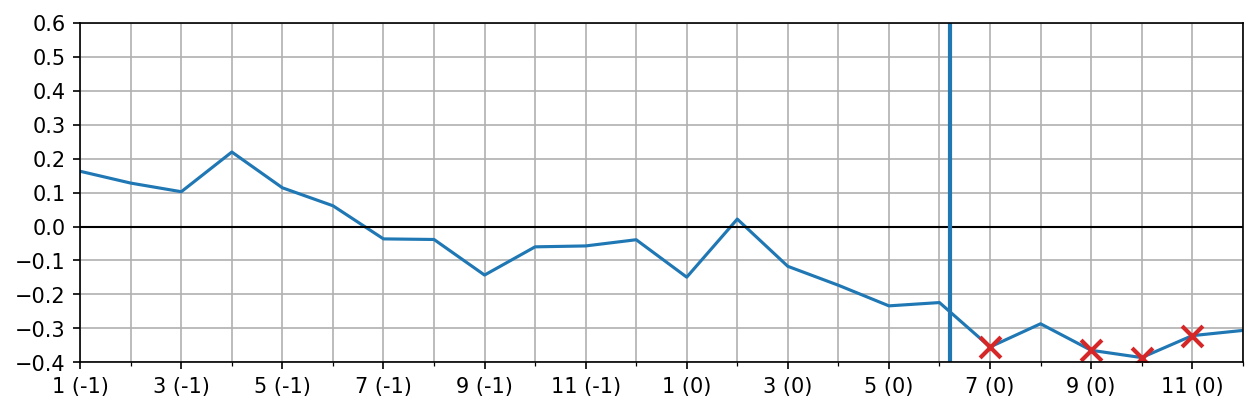

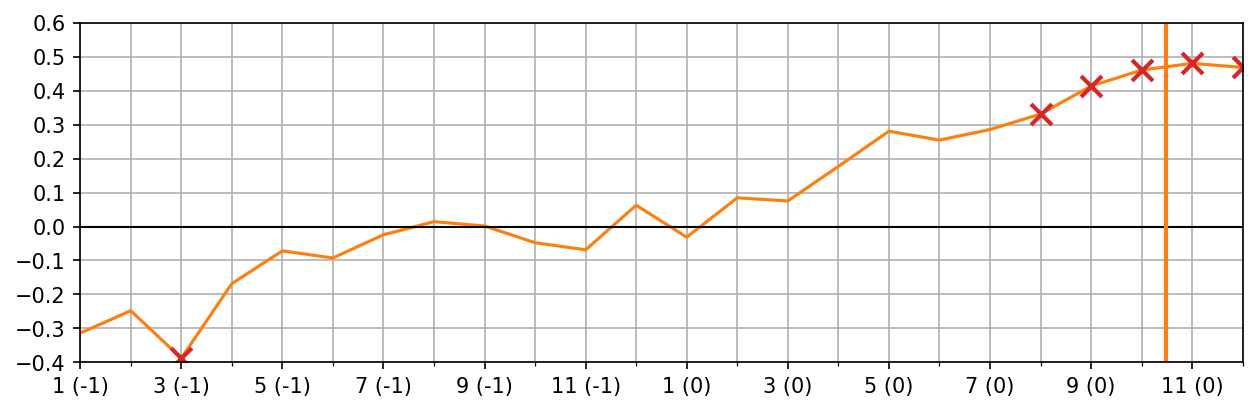

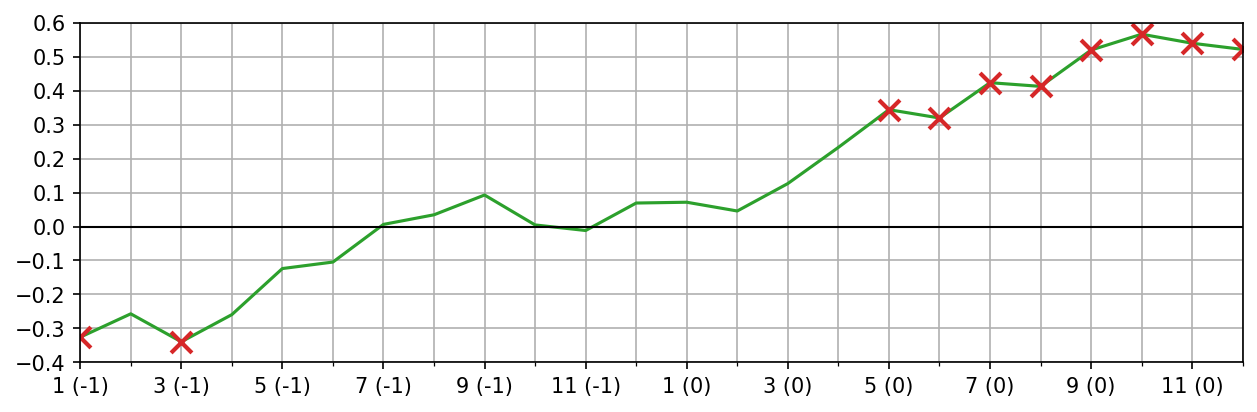

In [113]:
# Graficamos.

mean = [6.200, 10.484, 20]
color = ["tab:" + x for x in ["blue", "orange", "green"]]

for i in range(len(ENSO)):

    fig, ax = plt.subplots()
    fig.set_facecolor("w")
    fig.set_size_inches(10, 3)
    fig.set_dpi(150) 

    ax.plot(ENSO[i]["Month"], ENSO[i]["Correlation"], color = color[i])

    ax.plot( (-12, 12), (0, 0), color = "k", linewidth = 1 )
    ax.plot( [mean[i]] * 2, (-0.4, 0.6), color = color[i], linewidth = 2 )

    for j in ENSO[i].itertuples():
        if j[4]:
            ax.scatter( j[2], j[3], color = "tab:red", marker = "x",
                linewidth = 2, s = 100, zorder = 2)

    ax.set_xlim(-11, 12)
    ax.set_ylim(-0.4, 0.6)
    ax.set_yticks(np.arange(-0.4, 0.7, 0.1))
    ax.set_xticks(np.arange(-11, 13, 2.0))
    ax.set_xticks(np.arange(-11, 13, 1.0) , minor = True )
    ax.set_xticklabels( [f"{x} (-1)" for x in range(1, 13, 2)] 
        + [f"{x} (0)"  for x in range(1, 13, 2)] )
    ax.grid(which = "both")